<a href="https://colab.research.google.com/github/katsudonik/ExcelTools/blob/master/deep_learning/image_analyze/measure_from_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!git clone https://github.com/shohei/measure-from-image.git

fatal: destination path 'measure-from-image' already exists and is not an empty directory.


In [0]:
import numpy as np 
import pandas as pd 
from skimage.data import imread
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2

In [0]:
width = 3.5

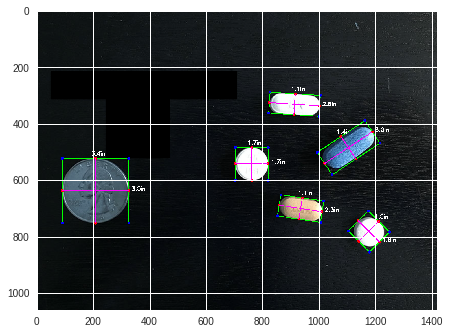

In [25]:
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import imutils

def midpoint(ptA, ptB):
  return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)


# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread('measure-from-image/ex.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
 
# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
 
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
 
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

# loop over the contours individually
orig = image.copy()
for c in cnts:
	# if the contour is not sufficiently large, ignore it
	if cv2.contourArea(c) < 100:
		continue
 
	# compute the rotated bounding box of the contour
	box = cv2.minAreaRect(c)
	box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
	box = np.array(box, dtype="int")
 
	# order the points in the contour such that they appear
	# in top-left, top-right, bottom-right, and bottom-left
	# order, then draw the outline of the rotated bounding
	# box
	box = perspective.order_points(box)
	cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
 
	# loop over the original points and draw them
	for (x, y) in box:
		cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
	# unpack the ordered bounding box, then compute the midpoint
	# between the top-left and top-right coordinates, followed by
	# the midpoint between bottom-left and bottom-right coordinates
	(tl, tr, br, bl) = box
	(tltrX, tltrY) = midpoint(tl, tr)
	(blbrX, blbrY) = midpoint(bl, br)
 
	# compute the midpoint between the top-left and top-right points,
	# followed by the midpoint between the top-righ and bottom-right
	(tlblX, tlblY) = midpoint(tl, bl)
	(trbrX, trbrY) = midpoint(tr, br)
 
	# draw the midpoints on the image
	cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
 
	# draw lines between the midpoints
	cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
		(255, 0, 255), 2)
	cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
		(255, 0, 255), 2)

	# compute the Euclidean distance between the midpoints
	dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
	dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
 
	# if the pixels per metric has not been initialized, then
	# compute it as the ratio of pixels to supplied metric
	# (in this case, inches)
	if pixelsPerMetric is None:
		pixelsPerMetric = dB / width

	# compute the size of the object
	dimA = dA / pixelsPerMetric
	dimB = dB / pixelsPerMetric
 
	# draw the object sizes on the image
	cv2.putText(orig, "{:.1f}in".format(dimA),
		(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
	cv2.putText(orig, "{:.1f}in".format(dimB),
		(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
  
plt.imshow(orig)
plt.show()